In [1]:
import torch, torchvision, PIL, numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL
import matplotlib.patches as patches
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


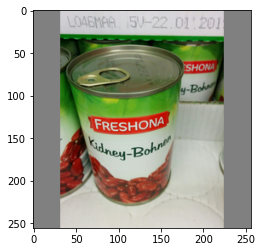

In [4]:
#test to make sure i have the right directory
plt.imshow(PIL.Image.open('/content/drive/MyDrive/freiburg_groceries_dataset/images/BEANS/BEANS0000.png'))

In [5]:
ds_dir = '/content/drive/MyDrive/freiburg_groceries_dataset'

In [6]:
xform = torchvision.transforms.Compose([torchvision.transforms.Resize((299,299)), torchvision.transforms.ToTensor()]) 
#xform = torchvision.transforms.Compose([torchvision.transforms.Resize(299),
#    torchvision.transforms.CenterCrop(299),
#    torchvision.transforms.ToTensor(),
#    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
#xform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) 
ds = torchvision.datasets.ImageFolder(ds_dir, transform=xform)

In [7]:
n_all = len(ds)
n_train = int(0.8 * n_all)
n_test = n_all - n_train

rng = torch.Generator().manual_seed(291)
ds_train, ds_test = torch.utils.data.random_split(ds, [n_train, n_test], rng)

In [8]:
ds[0][0].shape

torch.Size([3, 299, 299])

In [9]:
loader_train = torch.utils.data.DataLoader(ds_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size = 4, shuffle=True)

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class Food(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv2d_1 = torch.nn.Conv2d(3, 10, 3, 1, 1)
        self.relu_1 = torch.nn.ReLU()
        self.conv2d_2 = torch.nn.Conv2d(10, 20, 3, 1, 1)
        self.relu_2 = torch.nn.ReLU()
        self.conv2d_3 = torch.nn.Conv2d(20, 25, 3, 1, 1)
        self.relu_3 = torch.nn.ReLU()
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv2d_1(x), 25))
        x = F.relu(F.max_pool2d(self.conv2d_2(x), 25))
        x = F.relu(F.max_pool2d(self.conv2d_3(x), 25))
        x = x.view(x.shape[0],-1)
        return x

model = Food()

Either the above code box or the below code box

In [11]:
model = torchvision.models.inception_v3(pretrained=True)
## model.fc = torch.nn.Sequential(
   # torch.nn.Conv2d(model.fc.in_features, 100, 3, 1, 1),
   # torch.nn.ReLU(),
   # torch.nn.Conv2d(100, 60, 3, 1, 1),
   # torch.nn.ReLU(),
   # torch.nn.Conv2d(60, 25, 3, 1, 1),
   # torch.nn.ReLU()
#)
model.AuxLogits.fc = torch.nn.Linear(768, 25)
model.fc = torch.nn.Linear(2048, 25)

#model.fc = torch.nn.Linear(model.fc.in_features, 25)
#torch.nn.init.xavier_uniform_(model.fc.weight)



Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [54]:
def init_weights(m):
    if type(m) == torch.nn.Conv2d: #changed from torch.nn.Linear
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

model.fc.apply(init_weights)

Linear(in_features=2048, out_features=25, bias=True)

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
model_ft = torchvision.models.inception_v3(pretrained=True)
set_parameter_requires_grad(model_ft, True)
# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 25)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,25)
input_size = 299

In [22]:
model = model_ft

In [26]:
device = torch.device('cuda:0')
model = model.to(device)

In [25]:
criterion = torch.nn.CrossEntropyLoss()

def run_test(model):
    nsamples_test = len(ds_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            samples = samples.to(device)
            labels = labels.to(device)
            outs,_ = model(samples) #tried (samples[None, ...]
            loss = criterion(outs, labels)
            _, preds = torch.max(outs, 1)
            loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
    return loss / nsamples_test, correct / nsamples_test

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [28]:
def run_train(model, opt, sched):
    nsamples_train = len(ds_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for samples, labels in loader_train:
            #samples = torch.nn.functional.pad(samples, (22,21,22,21), mode='constant') #tried this padding instead of resizing
            #samples.view(4, -1, 299, 299) #tried
            #samples = samples.unsqueeze(0) #tried
            #samples.view(4,3,299,299)
            #samples = samples.unsqueeze(dim=0) #tried
            #samples = net(distfunc.unsqueeze(dim=1)) #tried
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs, aux_outputs = model(samples) #tried (samples[None, ...])
            _, preds = torch.max(outs, 1)
            loss = criterion(outs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss + 0.4*loss2
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.data)
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [31]:
def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        #loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}")
        #, test loss {loss_test:.4f} acc {acc_test:.4f}

In [ ]:
run_all(model, optimizer, scheduler, 10)

In [ ]:
%debug 

